In [8]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import cv2
from skimage import color

import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm

## Model

In [9]:
def double_convs(in_channels, out_channels):
    conv_layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

    return conv_layers

def expansion_block(upsample_layer, conv_layer, inp, concat_inp):
    mask = upsample_layer(inp)
    mask = torch.concat([concat_inp, mask], dim=1)
    mask = conv_layer(mask)

    return mask


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #contraction path
        self.contrac1 = double_convs(in_channels, 64)
        self.contrac2 = double_convs(64, 128)
        self.contrac3 = double_convs(128, 256)
        self.contrac4 = double_convs(256, 512)
        self.contrac5 = double_convs(512, 1024)

        #expansion path
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.double_conv1 = double_convs(1024, 512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.double_conv2 = double_convs(512, 256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.double_conv3 = double_convs(256, 128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.double_conv4 = double_convs(128, 64)

        #output layer
        self.out = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.Conv2d(64, out_channels, kernel_size=1)
            )

    def forward(self, image):
        #contraction
        cntrc_out1 = self.contrac1(image) #->
        out1 = self.max_pool(cntrc_out1)
        
        cntrc_out2 = self.contrac2(out1) #->
        out2 = self.max_pool(cntrc_out2)

        cntrc_out3 = self.contrac3(out2) #->
        out3 = self.max_pool(cntrc_out3)

        cntrc_out4 = self.contrac4(out3) #->
        out4 = self.max_pool(cntrc_out4)

        cntrc_out5 = self.contrac5(out4)

        #expansion
        mask = expansion_block(self.upsample1, self.double_conv1, cntrc_out5, cntrc_out4)
        mask = expansion_block(self.upsample2, self.double_conv2, mask, cntrc_out3)
        mask = expansion_block(self.upsample3, self.double_conv3, mask, cntrc_out2)
        mask = expansion_block(self.upsample4, self.double_conv4, mask, cntrc_out1)

        #output
        output = self.out(mask)

        return output

In [10]:
model = UNet(3, 22)

In [11]:
checkpoint = torch.load("../model/model.pt", map_location="cpu")
model_state = checkpoint['model_state_dict']

In [12]:
model.load_state_dict(model_state)

<All keys matched successfully>

## Transforming Inputs and Outputs

In [13]:
class config:
    N_COLORS = 22
    COLORS = np.array([[0.658463, 0.178962, 0.372748, 1.      ],
       [0.428768, 0.09479 , 0.432412, 1.      ],
       [0.615513, 0.161817, 0.391219, 1.      ],
       [0.846709, 0.297559, 0.244113, 1.      ],
       [0.447428, 0.101597, 0.43108 , 1.      ],
       [0.50973 , 0.123769, 0.422156, 1.      ],
       [0.002267, 0.00127 , 0.01857 , 1.      ],
       [0.980824, 0.572209, 0.028508, 1.      ],
       [0.64626 , 0.173914, 0.378359, 1.      ],
       [0.964394, 0.843848, 0.273391, 1.      ],
       [0.190367, 0.039309, 0.361447, 1.      ],
       [0.949545, 0.955063, 0.50786 , 1.      ],
       [0.60933 , 0.159474, 0.393589, 1.      ],
       [0.522206, 0.12815 , 0.419549, 1.      ],
       [0.087411, 0.044556, 0.224813, 1.      ],
       [0.013995, 0.011225, 0.071862, 1.      ],
       [0.004547, 0.003392, 0.030909, 1.      ],
       [0.453651, 0.103848, 0.430498, 1.      ],
       [0.962517, 0.851476, 0.285546, 1.      ],
       [0.379001, 0.076253, 0.432719, 1.      ],
       [0.553392, 0.139134, 0.411829, 1.      ],
       [0.851384, 0.30226 , 0.239636, 1.      ]])
    MODEL = model

In [14]:
def transform_inputs(image_arr):
    transforms = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
    ])

    trnsfrmd = transforms(image=image_arr)

    image = trnsfrmd['image']
    
    return image

In [15]:
def get_output(model, image):
    image = image.unsqueeze(0)
    
    logits = model(image.float())
    probs = logits.softmax(axis=1)
    probs = probs[0]
    pred = torch.argmax(probs, axis=0)
    pred *= 10
    
    return pred.numpy()

In [16]:
def get_results(frame):
    md_input = transform_inputs(frame)
    
    pred_mask = get_output(config.MODEL, md_input)
    
    md_input = md_input.permute(1,2,0).numpy()
    
    result_image = color.label2rgb(pred_mask, md_input, colors=config.COLORS, alpha=0.7)
    
    return result_image

In [17]:
data = pd.read_csv('../dataset/preprocessed_data.csv')

In [18]:
idx = 1

In [19]:
mask_path = data.loc[idx, 'mask']
img_path = data.loc[idx, 'images']

In [20]:
image = Image.open(img_path)
mask = Image.open(mask_path)

In [21]:
image_arr = np.array(image)
mask_arr = np.array(mask)
combined_inp = color.label2rgb(mask_arr, image_arr, colors=config.COLORS, alpha=0.7)

In [22]:
result = get_results(image_arr)

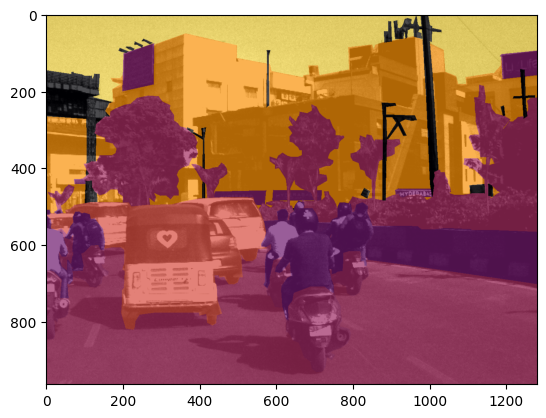

In [23]:
plt.imshow(combined_inp)

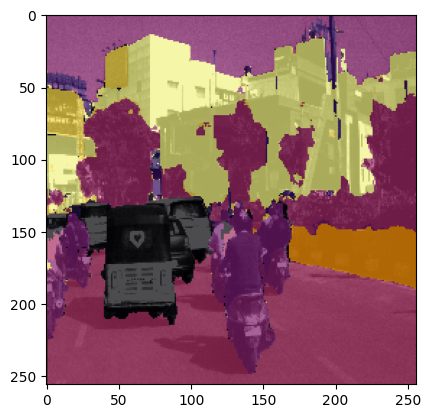

In [24]:
plt.imshow(result)

# converting video to frames

In [18]:
def get_frames(path):
  
    video = cv2.VideoCapture(path)
  
    # Used as counter variable
    count = 0
  
    # checks whether frames were extracted
    success = 1
  
    while success:
  
        success, image = video.read()
        
        if not success:
            break
        # Saves the frames with frame-count
        cv2.imwrite(f"../archive/frames/sample_vid/frame{count}.jpg", image)
  
        count += 1

In [ ]:
get_frames("../archive/sample_vid.mp4")

# Predicting on frames

In [27]:
path = "../archive/videos/2. sample_data/input_frames"
frame_names = os.listdir(path)

In [23]:
len(frame_names)

99

In [24]:
frame_names[0]

'002054_leftImg8bit.png'

In [19]:
def predict_frames(frame_names, root_path):
    frame_root_path = root_path + "/input_frames"
    for frame in tqdm(frame_names):
        frame_path = os.path.join(frame_root_path, frame)

        img = Image.open(frame_path)
        arr = np.array(img)

        result_arr = get_results(arr)

        result_img = Image.fromarray((result_arr*255).astype(np.uint8), 'RGB')
        result_img = result_img.resize(img.size)

        result_img.save(f"{root_path}/result_images/{frame}")

In [29]:
root_path = "../archive/videos/2. sample_data"
predict_frames(frame_names, root_path)

  0%|          | 0/99 [00:00<?, ?it/s]

# Converting Frame to Video

In [25]:
def generate_video(image_folder, video_name):      
    images = os.listdir(image_folder)
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height)) 
  
    # Appending the images to the video one by one
    for image in tqdm(images):
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation

    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated

In [30]:
image_folder = "../archive/videos/0. sample_data/result_images"
video_name = '../archive/videos/0. sample_data/result_video1.avi'

In [31]:
generate_video(image_folder, video_name)

  0%|          | 0/63 [00:00<?, ?it/s]

In [5]:
import moviepy.editor as moviepy

In [7]:
avi_file = "../app/tmpaxwelplm.avi"
clip = moviepy.VideoFileClip(avi_file)
mp4_file = avi_file[:-3]+"mp4"

clip.write_videofile(mp4_file)

Moviepy - Building video ../app/tmpaxwelplm.mp4.
Moviepy - Writing video ../app/tmpaxwelplm.mp4



Moviepy - Done !
Moviepy - video ready ../app/tmpaxwelplm.mp4
